# Acoustic Positioning System Lab 1: Cross Correlation and TDOAs

### EECS16A: Designing Information Devices and Systems I, Summer 2020

#### [Introduction](#w1)
#### [Task 1: Measuring the Similarity of Two Signals](#task1)
#### [Task 2: Extracting information](#task2)
#### [Task 3: Detecting Real Signals](#task3)
#### [Task 4: Separating Signals](#task4)
#### [Task 5: Computing Distances](#task5)
#### [Task 6: Testing with Real Data](#task6)

<a id='w1'></a>
## Introduction

This is a long lab, but it is all software. The entire lab is done in this Jupyter notebook.

There are various positioning systems that we use every day. The most commonly used one is the [Global Positioning System (GPS)](http://en.wikipedia.org/wiki/Global_Positioning_System). The navigation systems in cars, Google Maps, cell phones, and even rockets and spaceships all use GPS.

In this lab, we are going to explore the basics of these navigation systems and build our own. At the end of this lab, you will have written software (and tested it on real data) that can give you the location of a receiver in 2D space!

## Instructions
* Complete this lab by filling in all of the required sections, marked with "YOUR CODE HERE" or "YOUR COMMENTS HERE".
* When you finish, submit a checkoff request to get checked off for this lab. Be ready to answer a few questions to show your understanding of each section.
* Labs will be graded based on completion for teams of 2-4 students.
* You must only attend the lab section you are enrolled in.

### Run the cell below to import the necessary helper functions.

In [1]:
%pylab inline
%run support_code/helper_functions.py

Populating the interactive namespace from numpy and matplotlib



## Basic Principle of Operation
GPS satellites broadcast a variety of measurements including time from a very precise clock, as well as the satellite's position, velocity, etc. GPS receivers make use of the fact that light propagates at a known speed: $3\times 10^8 ms^{-1}$, so the receiver can compute distance from the satellite by measuring how long it takes the GPS signal to propagate from the satellite to the receiver.

<center>
<img src="img/wk1_standard_gps.png" align="center" style="height:250px">
    
**Source**: [Kathleen Cantner, AGI](http://www.earthmagazine.org/article/precise-fault-how-gps-revolutionized-seismic-research)
</center>

Just like the GPS, we will use speakers as our signal emitters (like the "GPS satellite"), and use microphones (our version of the "GPS radio chip") to receive the signals. Using the microphone, we have essentially created an Acoustic Positioning System (APS), as opposed to a Global Positioning System. We can determine distances to each emitter based on the delay between the times at which we receive each signal.

Let's start with the block diagram below illustrating the positioning process flow we'll implement in this lab.

<a id='background'></a>
## Extracting Information
The block diagram below shows a high level overview of the system. We begin by transmitting signals from the speakers. The combined signal is then recorded by the microphone and converted to a format that we can use for further processing. Next, the component signal from each speaker is identified from the received total signal using cross correlation analysis, and the corresponding time differences are used to determine locations.

<center>
<img src="img/signals.png" align="center" style="height:450px">
</center>

<a id='task1'></a>
## <font color="blue">Task 1: Measuring the Similarity of Two Signals
    
Just like real GPS, our APS setup will have multiple speaker-satellites emitting signals, and a single microphone receiver. The signal that we receive at the microphone will be a sum of the individual speaker outputs. We will sift through the microphone signal to find audio signals that are unique from each speaker. We will use a tool called **cross-correlation** to perform this sifting. In order to perform cross-correlation, we compare the signal we receive with stored copies of the signal generated by the speakers. 

**[Cross-correlation](http://en.wikipedia.org/wiki/Cross-correlation)** is a measure of similarity between two functions - in our case these 'functions' will be vectorized time domain signals. It is a mathematical operation defined by taking successive inner products as one vector 'slides past the other'. Intuitively this is a measure of the 'overlap' between two signals with respect to time. For discrete signals, the 'overlap' at time $t$ of the received signal and a copy of a particular speaker generated signal is the inner product of the received signal at that time and a shifted version of the stored copy. Both a mathematical definition and an animation are shown below where $x$ and $y$ are real valued functions.

From lecture, we have learnt how to use linear cross-correlation to calculate the cross correlation vector for two generic signals. We have not assumed that they are either period or aperiodic - linear cross correlation  works with any two finite length signals of potentially different lengths (we zero-pad the signals to align them). Let $\vec{x}$ and $\vec{y}$ be two generic signals. The $m^{th}$ element of the cross-correlation vector $\vec{\rho_{xy}}$ is defined below $(m=0,1,...,N-1)$:  

$$corr_{\vec{x}}(\vec{y})[m]=\vec{\rho_{xy}}[m] \stackrel{\mathrm{def}}{=} \sum_{n=-\infty}^{\infty} x[n] y[n-m]$$

<img src="img/square_triangle_xcorr.gif" border="0" alt="Animation demonstrating cross-correlation." style="height:300px">
<!--- <img src="img/cross_correlation_animation_auto-tune.gif" border="0" alt="Animation demonstrating cross-correlation."> --->

Let us first analyse linear cross-correlation as presented above. $\rho_{xy}[m]$ is an inner product of two vectors that have been zero-padded: $\vec{x}[n]$ and $\vec{y}[n-m]$, where $m$ is an integer between $-\infty$ to $\infty$. $\vec{y}[n-m]$ is a shifted version of $\vec{y}[n]$. Specifically, $\vec{y}[n-m]$ is $\vec{y}[n]$ delayed by $m$ time steps. In the above animation, the red signal is being shifted and the value of the black signal at a particular time is the inner product of the shifted red signal at this time, and the blue signal. Observe that the red signal has been zero-padded on both sides to match the length of the blue signal. The blue signal is also zero-padded such that the correlation vector (black) contains entries for all valid 'overlaps'.

**However**, in this lab we will be using **infinitely periodic linear cross correlation**. The difference between finite linear cross correlation and infinitely periodic cross correlation is that we assume that <span style='color:red'><b> we treat the signal as repeating infinitely in time instead of zero padding the signals.</b></span> We instead effectively pad the original signal with itself infinitely many times and choose a finite cross-correlation vector length.

Let us understand this operation better with an example. Run the code below to view a demo of how infinitely periodic cross correlation works. The demo shows the inputs and outputs to an infinitely periodic cross correlation function, as well as the relevant shifts and periodicity of the involved signals. Notice how the stationary signal 'wraps round' periodically. 

input stationary_signal: [3 1 0 0 0 1]
input sliding_signal: [1 2 3 2 1 0]
cross-correlation:[5, 2, 5, 10, 13, 10]


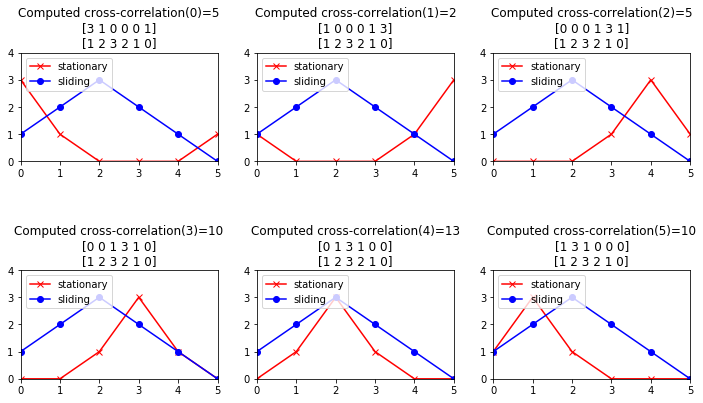

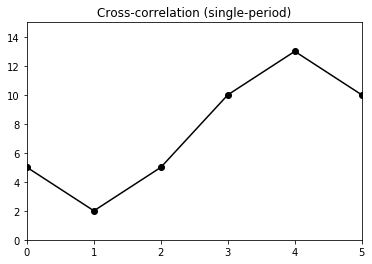

In [2]:
cross_corr_demo_1()

As shown in the example above, for $\vec{x} = \begin{bmatrix} 3 & 1 & 0 & 0 & 0 & 1\end{bmatrix}^T$ and $\vec{y} = \begin{bmatrix} 1 & 2 & 3 & 2 & 1 & 0\end{bmatrix}^T$, the resultant infinitely periodic cross-correlation vector is:

$$ v = \begin{bmatrix} 5 \\ 2 \\ 5 \\ 10 \\ 13 \\ 10 \end{bmatrix} $$

Where $$ v[0] = \left< \begin{bmatrix} 3 \\ 1 \\ 0 \\ 0 \\ 0 \\ 1 \end{bmatrix}, \begin{bmatrix} 1 \\ 2 \\ 3 \\ 2 \\ 1 \\ 0 \end{bmatrix} \right> = 5 \hspace{15pt}
v[1] = \left< \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \\ 1 \\ 3 \end{bmatrix}, \begin{bmatrix}  1 \\ 2 \\ 3 \\ 2 \\ 1 \\ 0 \end{bmatrix}\right> = 2 \hspace{15pt} ... $$


**<font color="red"> Based on the the cross-correlation plot, how many samples (and in which direction) do you need to shift the blue signal by to maximize the correlation between the two signals?**

**`YOUR ANSWER HERE`**

It is natural to ask what would happen if we cross-correlate signals for more than one period. **We will analyse this case by repeating the example above for two periods instead.**

input stationary signal: [3 1 0 0 0 1 3 1 0 0 0 1]
input sliding signal: [1 2 3 2 1 0 1 2 3 2 1 0]
cross-correlation:[10, 4, 10, 20, 26, 20, 10, 4, 10, 20, 26, 20]


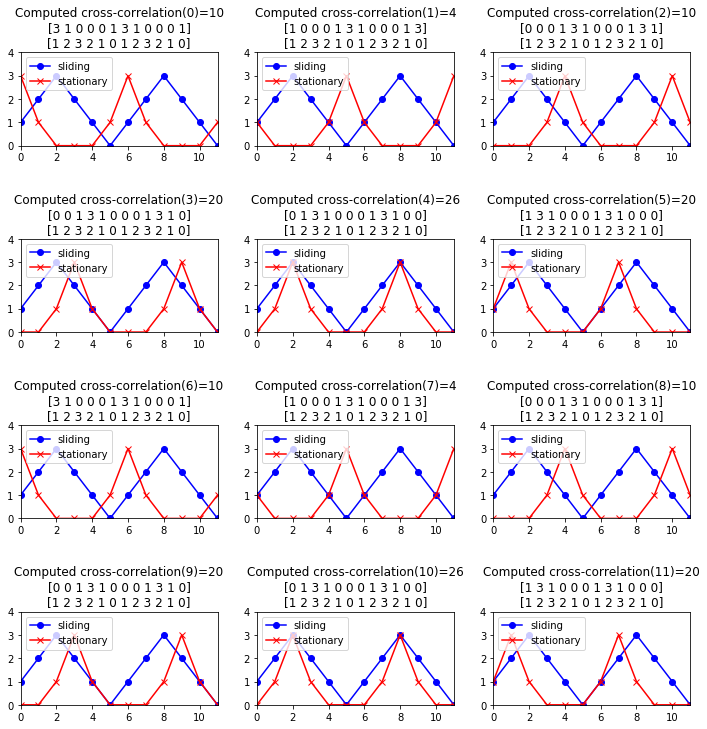

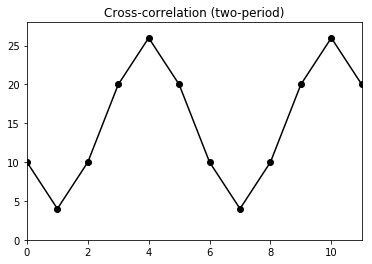

In [3]:
cross_corr_demo_2()

For two periods, $\vec{x} = \begin{bmatrix} 3 & 1 & 0 & 0 & 0 & 1 & 3 & 1 & 0 & 0 & 0 & 1 \end{bmatrix}^T$ and $\vec{y} = \begin{bmatrix} 1 & 2 & 3 & 2 & 1 & 0 & 1 & 2 & 3 & 2 & 1 & 0 \end{bmatrix}^T$ .

The infinitely periodic linear cross-correlation vector is now:

$$ v = \begin{bmatrix} 10 \\ 4 \\ 10 \\ 20 \\ 26 \\ 20 \\ 10 \\ 4 \\ 10 \\ 20 \\ 26 \\ 20 \end{bmatrix}$$

**<font color="red"> What is the relationship between the two-period cross-correlation and the single-period cross-correlation?** <br>

**`YOUR ANSWER HERE`**

Unsurprisingly, the  two-period cross-correlation vector does not give us any new information. The two-period cross-correlation vector is simply the single period vector repeated twice. 

**NOTE**: In the real world, we might cross-correlate $\vec{x}$ and $\vec{y}$ multiple times, because $\vec{x}$ and $\vec{y}$ may not be perfectly $N$-periodic due to noise that affects the values of the signal at certain times. We compensate by using multiple periods of the signals when calculating cross-correlations so that we have multiple copies of the cross-correlation data. Data redundancy for noise reduction will be explored later in this lab.

**<font color="red">In Homework 12, you used a wrapper function for `np.correlate` to calculate linear cross correlation. You are given a similar cross correlation function below that performs infinitely periodic cross correlation on two signals using `np.correlate`.**
    
```python
def cross_correlation(stationary_signal, sliding_signal):
    """Compute the cross_correlation of two given signals    
    Args:
    stationary_signal (np.array): input signal 1
    sliding_signal (np.array): input signal 2
    
    Returns:
    cross_correlation (np.array): infinitely periodic cross-correlation of stationary_signal and sliding_signal
    
    >>> cross_correlation([0, 1, 2, 3], [0, 2, 3, 0])
    [8, 13, 6, 3]
    """
    inf_stationary_signal = np.concatenate((stationary_signal ,stationary_signal))
    entire_corr_vec = np.correlate(inf_stationary_signal, sliding_signal, 'full')
    return entire_corr_vec[len(sliding_signal)-1: len(sliding_signal)-1 + len(sliding_signal)]

```



Run the following cell to display an interactive plot of `stationary_signal`, `sliding_signal`, and the resulting infinite periodic linear cross correlation vector. Set the offset slider to different values to visualize the "infinite periodic" part of the stationary signal and understand the relationship between the offset and correlation result.

In [4]:
inf_periodic_cross_corr()

interactive(children=(IntSlider(value=0, description='offset', max=8, min=-8), Output()), _dom_classes=('widge…

**Notice that the correlation is highest when the orange and blue signals overlap the most, and the value is lowest when the signals overlap the least.** This elucdates how cross correlation measures the similarity between two signals at different time shifts.

<a id='task2'></a>
## <font color="blue">Task 2: Extracting Information
We will now explore how cross-correlation is used in positioning systems.

The acoustic positioning system we will design uses speakers as *beacons* that each transmit a unique *beacon signal*. The beacon signals will be used to determine the position of a *receiver* - a microphone. Figure 3a shows examples of waveforms generated by a two beacon system. The beacons are synchronized, i.e all beacon signals are transmitted from their respective beacons simultaneously. Figure 3b demonstrates an exemplar scenario wherein the receiver is further away from beacon 2 than beacon 1, consequently receiving the beacon signal from beacon 2 after the beacon signal from beacon 1.
**Figure 3**
<img src="img/Slide2.tiff.png" width=700px></img>

The raw signal that the receiver measures shown in Figure 4a (black), is a superposition of beacon signal 1 and a delayed beacon signal 2. We can cross-correlate this received signal  with stored copies of each unique beacon signal to determine when each beacon signal arrived at the receiver. For a given beacon signal, this will be the time index that corresponds to the maximum cross-correlation with that particular beacon signal. Notice that in Figure 4b, the cross-correlation of the received signal with a stored copy of beacon signal 1 attains its maximum 3 milliseconds before the cross-correlation of the received signal with beacon signal 2 is maximized. We can therefore infer that beacon signal 1 was received before beacon signal 2, and that the distance of the microphone from the first beacon is less than the distance of the microphone from the second beacon.

**Figure 4**
<img src="img/Slide3.tiff.png" width=700px></img>

Although though the two beacon signals are different, notice that the cross correlation **between the two beacon signals** is still non-zero. This is fine for our purposes, and will still allow us for robust identification of beacon signals, as long as the cross correlation between different beacon signals is small, while the cross correlation of a beacon signal with itself (autocorrelation) is large only when the beacon is not shifted. If these conditions hold, we can still identify the beacon signals that a received signal is composed of, since the cross correlation between a beacon signal and the received signal at the correct offset will always be considerably larger than cross correlation values that correspond to the correlation between two different beacon signals, or cross correlation values that correspond to the correlation between a beacon signal and a shifted version of itself.

Real Global Positioning Systems deal with this problem by using pseudorandom binary sequences (signals composed of just 1s and 0s), also known as **Gold Codes**, constructed with the properties described above:  small cross-correlation at all shifts between **different** gold codes, small autocorrelation at non-zero shifts, and a large auto-correlation value at zero shift. The theory and implementation of these signals is beyond the scope of this class. We have provided a large set of Gold Codes that are designed to work well for our purposes. 

Run the next cell to simulate three beacons that each produce a unique gold code.

In [5]:
sliderPlots()

interactive(children=(IntSlider(value=0, description='delay_samples0', max=500, min=-500, step=10), IntSlider(…

The sliders control the delay of each beacon (in units of samples). Experiment with the delay values for each beacon and observe how the cross-correlation plot changes. If the slider doesn not appear or work for some reason, you can manually change the values in the tuples for `delay_samples0`, `1`, and `2`. For example, try `delay_samples0 = (-300, 700, 10)` and see how the plot changes.

**<font color="red">Pick some non-zero values for the sliders and comment on the offset corresponding to maximum cross correlation. What is the relationship between the this offset and the delay for this part?**

**`YOUR ANSWER HERE`**

If you are given some beacon signals (gold codes) and a received signal that is a composition of these gold codes at different delays, how would you calculate when (in samples) each beacon signal arrived at the receiver?

**<font color="red">Implement a helper function `identify_peak` which takes in a signal with a single global maximum as an input and returns the index of this global maximum.** <font color="red">Note that the signals are zero-indexed, as shown in the example input and output of the function below.

In [ ]:
def identify_peak(signal):
    """Returns the index of the peak of the given signal.
    Args:
    signal (np.array): input signal
    
    Returns:
    index (int): index of the peak
    
    >>> identify_peak([1, 2, 5, 7, 12, 4, 1, 0])
    4
    >>> identify_peak([1, 2, 2, 199, 23, 1])
    3
    """
    # YOUR CODE HERE

**<font color="red">Verify the following test for `identify_peak`.**

In [ ]:
test(cross_correlation, identify_peak, arrival_time, 2)

<a id='task3'></a>
## <font color="blue">Task 3: Detecting Real Signals

Now that we have reviewed the theory behind cross-correlation and how it can be used to determine distances, we will test the functions you have written with real data.

For your convenience, we have pre-recorded some audio samples for you to use for the rest of this lab, from the real setup you will be using in APS 2. The code block below will load a test signal (in blue) and test the code you have written and display the signal cross correlated with four known signals.

In [ ]:
load_corr_sig(identify_peak)

We should have four nice peaks after doing the cross-correlation. 

<a id='task4'></a>
# <span style="color:blue">Task 4: Separating Signals and Beacons</span>

Recall from before: even though we only have a single microphone receiving signals from multiple beacons, we can use cross-correlation to determine the time (in units of samples) at which each signal arrives. We call this process *signal separation*. We have provided you code to do this in the `helper_functions.py` - read it over below.

```python
def separate_signal(raw_signal):
    """Separate the beacons by computing the cross correlation of the raw signal 
    with the known beacon signals.

    Args:
    raw_signal (np.array): raw signal from the microphone composed of multiple beacon signals
    
    Returns (list): each entry should be the cross-correlation of the signal with one beacon
    """
    Lperiod = len(beacon[0])
    Ncycle = len(raw_signal) // Lperiod
    for ib, b in enumerate(beacon):
        c = cross_correlation(raw_signal[0:Lperiod],b)
        # Iterate through cycles
        for i in range(1,Ncycle):
            c = np.hstack([c, cross_correlation(raw_signal[i*Lperiod:(i+1)*Lperiod], b)])
        if (ib==0): cs = c
        else:       cs = np.vstack([cs, c])
    return cs
```

Before we move on to converting time differences into positions, we first need to consider several potential issues with our positioning system. 

1. Our beacons play on a loop at a fixed rate, however we don't know when in the loop we started recording. For example, if we record for exactly the number of samples of a beacon, we may have started recording after some of the beacon signals reached the microphone.
<br/><br/>
3. You may notice that the height of the peaks in your final output is dependent on the volume of the speakers. Additionally, like all of the other systems, the output will be affected by noise.


The beacon signals repeat every **230 ms**, and we record for approximately **2.5 s**. Because of this we are recording the **same** beacon signals multiple times, and assuming our microphone isn't moving we only need **one set of measurements** to determine the time differences between them. 

**<span style="color:red">How can we use our full recorded signal to solve some of the problems above and make our system more robust? Hint: We only need one recording of the beacon signals, but we wind up with many repeats. How can we use this 'extra' information to our advantage?</span>**

**`YOUR ANSWER HERE`**

**<span style="color:red">We have implemented a function that makes this improvement below. Review the `average_sigs()` function and be prepared to explain what it does.</span>**

```python
def average_sigs(cross_correlations):
    Lperiod = len(beacon[0])
    Ncycle = len(cross_correlations[0]) // Lperiod
    avg_sigs = []
    for c in cross_correlations:
        reshaped = c.reshape((Ncycle,Lperiod))
        averaged = np.mean(np.abs(reshaped),0)
        avg_sigs.append(averaged)

    return avg_sigs
```

**<span style="color:red">Run the code below to plot how the quality of the signal improves after running this function.</span>**
<br/>
Note: Each of these blocks deals with $>100k$ samples, so they may take several seconds to run.

In [ ]:
plot_average_sigs()

**<span style="color:red">What is the effect of averaging? Why would this be useful?</span>**

**`YOUR ANSWER HERE`**

<a id='task5'></a>
# <span style="color:blue">Task 5a: Computing Distances</span>

We can now determine the time at which each signal arrived with respect to the first sample of the recording. Unfortunately, this time in samples has no direct relationship to physical distances. As previously discussed, our recordings start at arbitrary times with respect to the beacons. However, we can compute arrival times relative to a **particular beacon.**

For example, if our `cross-correlation` tells us that **`beacon0`** arrives at $t_0 = 1120$ and **`beacon1`** arrives at $t_1 = 1420$ we can see that **`beacon1`** arrives $300$ samples after **`beacon0`**.
We call the relative time of arrival (in units of samples) **offsets** and define the **offset** of all other beacons with respect to **`beacon0`**.

**<span style="color:red">According to our definition above what is the offset of `beacon0`?</span>**

**`YOUR ANSWER HERE`**

**<span style="color:red">If `beacon2` arrives 450 samples later than `beacon0`, what is the *time* difference of arrival (in seconds) given that our sampling rate is $f_s=44100$ Hz?</span>**

**`YOUR ANSWER HERE`**

In [ ]:
plot_shifted(identify_peak)

Note that sometimes a beacon can arrive earlier than our reference signal, **`beacon0`**. More intuitively, these beacons have a *negative offset*. You can think of this as the plot being a defined number of samples and the end wrapping around to represent negative values.
We have provided you code to center the received signal about **`beacon0`** at sample 0 as done in the two plots above.

**<span style="color:red">Complete the function below which returns offsets (in units of samples) given a list of input signals.</span>**

In [ ]:
def identify_offsets(averaged):
    """ Identify peaks in samples.
    The peaks of the signals are shifted to the center.
    
    Functions to Use: identify_peak
    
    Args:
    averaged (list): the output of the average_sigs() function (a list of single period cross correlated sigs)
    
    Returns (list): a list corresponding to the offset of each signal in the input
    """
    # Reshaping the input so that all of our peaks are centered about the peak of beacon0
    shifted = [np.roll(avg, len(averaged[0]) // 2 - identify_peak(averaged[0])) for avg in averaged]
    beacon0_offset = identify_peak(shifted[0])

    # shifted:
    #     All the signals shifted so beacon 0 is in the middle of the signal
    # beacon0_offset:
    #     The absolute index that beacon 0 starts on
    # YOUR TASK: Return a list that includes the relative indexes of where each beacon starts relative to
    #            when beacon 0 starts. This means that beacon 0's offset should be 0.
    
    # Use `shifted` and `beacon0_offset` to determine the offsets of other beacons
    # YOUR CODE HERE

**<span style="color:red">Run the cell below to test identify_offsets().</span>**

In [ ]:
test_identify_offsets(identify_offsets, separate_signal, average_sigs)

We now need to convert the offsets we have computed in samples to the time difference of arrivals (TDOAs) we will use to determine positions.

**<span style="color:red">Given that our microphones sample at a rate of $f_s=44100$ Hz, complete the function `offset_to_tdoas` below which takes a list of offsets (for example the output of `identify_offsets`), and a sampling frequency and returns a list of TDOA's.</span>**
<br/>
*Hint: What is the relation between sampling frequency, number of samples, and time?*

In [ ]:
def offsets_to_tdoas(offsets, sampling_freq):
    """ Convert a list of offsets to a list of TDOA's
   
    Args:
    offsets (list): list of offsets in samples
    sampling_freq (int): sampling frequency in Hz
    
    Returns (list): a list of TDOAs corresponding to the input offsets
    """
    # YOUR CODE HERE

**<span style="color:red">Run the cell below to test offsets_to_tdoas().</span>**

In [ ]:
test_offsets_to_tdoas(offsets_to_tdoas)

# <span style="color:blue">Task 5b: Combining Functions</span>
We now have a variety of helper functions to perform each step of the calculations required to go from our microphone signal to a list of TDOAs with all the relevant intermediate steps.

**<span style="color:red">Implement a function that will take in the recorded microphone signal and output the offset in units of *samples*.</span>**

In [ ]:
def signal_to_offsets(raw_signal):
    """ Compute a list of offsets from the microphone to each speaker.
    
    Functions to use: separate_signal, average_sigs, identify_offsets
    
    Args:
    raw_signal (np.array): raw received signal from the microphone (e.g. no separation, averaging, etc).
    
    Returns (list): offset for each beacon (beacon0, beacon1, etc). in samples
    """
    # YOUR CODE HERE

We now have the offsets relative to a single beacon. If we were given a reference time for **`beacon0`** we can determine the total time for the sound wave to travel the distance from the speakers to our microphone. Knowing that the speed of sound is **340 m/s**, we can compute the distance from the microphone to each speaker, and use simple geometry to locate ourselves! This is exactly what GPS is doing, except with electromagnetic waves rather than sound waves.

**<span style="color:red">Implement a function, `signal_to_distances`, which takes a recorded signal and the time of arrival of the first beacon signal, and returns a list of the distance from the microphone to each speaker.</span>**
*Hint: You may wish to take advantage of a function that computes the offsets given the raw microphone signal.*

In [ ]:
v_air = 340.29
sampling_freq = 44100

def signal_to_distances(raw_signal, t0):
    """ Returns a list of distances from the microphone to each speaker.
    
    Functions to use: offsets_to_tdoas, signal_to_offsets
    
    Args:
    raw_signal (np.array): recorded signal from the microphone
    t0 (float): reference time for beacon0 in seconds
    
    Returns (list): distances to each of the speakers (beacon0, beacon1, etc). in meters
    
    You will have to use v_air and sampling_freq above
    """
    # YOUR CODE HERE

**<span style="color:red">Run the cell below to test signal_to_distances(). DO NOT move on before passing this test.</span>**

In [ ]:
test_signal_to_distances(signal_to_distances)

After computing the distances from each speaker, we can use the formula for distance $d = \sqrt{(x-x_{speaker})^2 + (y-y_{speaker})^2}$ to construct a system of equations and solve for our exact position! Rather than solving for our exact coordinates, we will visualize our position with respect to the beacons on a graph.

## Visualization

**<span style="color:red">Run the following block to simulate speakers located at (0, 0), (5, 0), (0, 5), (5, 5), (0, 2.5) on a 2D plane and a microphone located at (1.2, 3.6).</span>**

In [ ]:
# Assume the time of arrival of the first beacon is 0.011151468430462413.
received_signal = get_signal_virtual(x=1.2, y=3.6)
raw_signal = demodulate_signal(received_signal)
distances = signal_to_distances(raw_signal, 0.011151468430462413)
distances = distances[:5]
print(("The distances are: " + str(distances)))

# Plot the speakers
plot_speakers(plt, [(0, 0), (5, 0), (0, 5), (5, 5), (0, 2.5)], distances, xlim=(-8, 8), ylim=(-16/3, 16/3))
plt.show()

**<span style="color:red">Our current model relies on the fact that we know the time it took the first (0th) beacon to arrive, and assumes that all the distances from the speakers will land on one unique location. However, in the real world we do not know when the first beacon arrives, and noise contributions will always make the distances produces no unique solution for the location of the mic. This creates an over determined system that may not have a solution. We will learn a new technique in lecture to help circumvent the second issue, but we need a better model to take care of not knowing the first delay of arrival.</span>**

<a id='task6'></a>
# <span style="color:blue">Task 6: Testing signal_to_offsets with Real Data</span>

Lets start by reloading the recording we used earlier in the lab.

In [ ]:
received_signal = load('sig.npy')

# Plot the received signal
plt.figure(figsize=(18,4))
plt.plot(received_signal)

**<span style="color:red">Test your code (it's okay if you're +/- a couple from each offset).</span>**

In [ ]:
offsets = signal_to_offsets(demodulate_signal(received_signal))
print("Expected: " + str([0, 250, 540, -321]))
print("Got: " + str(offsets[:4]))

#### We are almost ready to locate ourselves. Next week will go over techniques to somehow get the first delay of arrival as well as approximate a solution for our over determined system.

<a id='checkoff'></a>
## Checkoff

When you are finished, please do the following:

1. Download this notebook as a PDF (either print preview or other way), to get ready to upload it.
2. Complete the check off assignment [APS 1 Checkoff](https://www.gradescope.com/courses/83747/assignments/384842/submissions/new) on Gradescope. You will need to complete all parts of the assignment, including checkoff links and related uploads to receive credit for this.
3. Upload your notebook to the APS 1 PDF Notebook Submission on Gradescope.